In [12]:
#motivation: separate memory cell channel for state preservation - controlled by gates
#forget gate: sigmoid layer - what day from previous state to discard
#input gate: sigmoid - what to keep, tanh - wht new to add
#output gate: what from memory cell is new hidden state to be used
#good for longterm trends and cyclical patterns


In [13]:
#Load import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #for LSTM sensitivity to df scale

In [14]:
import datetime
import yfinance as yf #for historical stock df
from datetime import timedelta


end_date = datetime.datetime.now()
start_date = end_date - timedelta(days=5*365)

print("Downloading historical df...")
df = pd.DataFrame(yf.download('RELIANCE.NS', start=start_date, end=end_date))

df.info()


C:\Users\anany\AppData\Local\Temp\ipykernel_19068\2258863162.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = pd.DataFrame(yf.download('RELIANCE.NS', start=start_date, end=end_date))
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1238 entries, 2020-08-20 to 2025-08-19
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Close, RELIANCE.NS)   1238 non-null   float64
 1   (High, RELIANCE.NS)    1238 non-null   float64
 2   (Low, RELIANCE.NS)     1238 non-null   float64
 3   (Open, RELIANCE.NS)    1238 non-null   float64
 4   (Volume, RELIANCE.NS)  1238 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.0 KB


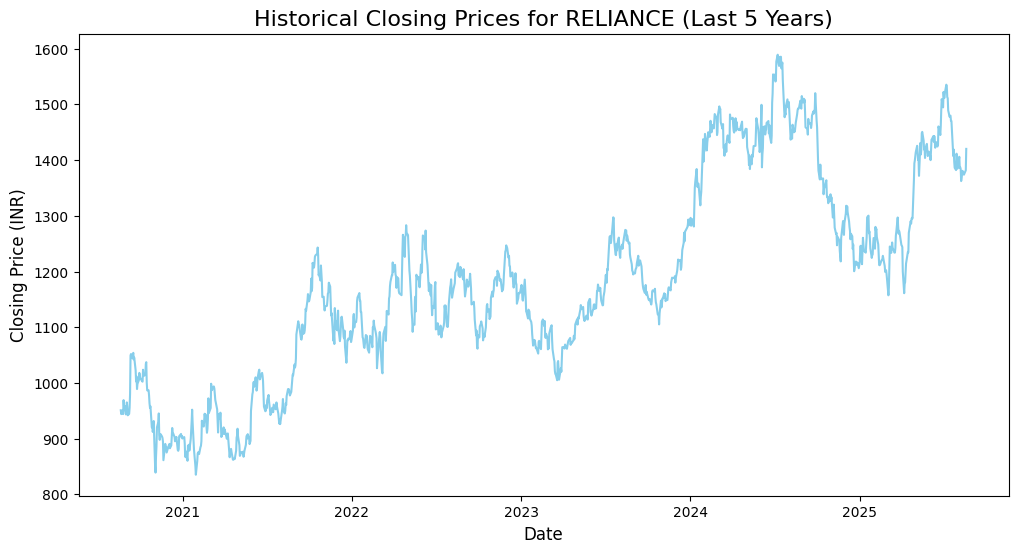

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Closing Price', color='skyblue')

plt.title(f'Historical Closing Prices for RELIANCE (Last 5 Years)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (INR)', fontsize=12)
plt.show()

In [16]:
len(df[df.isna().any(axis=1)]) #no nulls

scaler=MinMaxScaler(feature_range=(0,1))

dataset = df['Close'].values
training_size = int(np.ceil(len(dataset) * .80))

scaler = MinMaxScaler(feature_range=(0, 1))
scaledtrain = scaler.fit_transform(dataset[0:training_size, :])
#cannot use random train-test split for time-series analysis

scaledtest = scaler.transform(dataset[training_size:, :]) #the test set

In [17]:
look_back = 60 #60 day period
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0] #using column 0
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(scaledtrain, look_back)
X_test, y_test = create_dataset(scaledtest, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

model=Sequential()

model.add(LSTM(
    units=50,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1)
)) #50 neurons is enough complexity to form temporal patterns

model.add(Dropout(0.2)) #prevent overfitting

model.add(LSTM(
    units=50,
    return_sequences=False
)) #more depth more abstraction

model.add(Dropout(0.2))

model.add(Dense(units=1,kernel_regularizer=l2(0.01))) #output layer - uses linear activation

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')
print("\nTraining the model...")
history = model.fit(
    X_train,
    y_train,
    epochs=50,         
    batch_size=32      
)

print("\nModel training completed!")



Training the model...
Epoch 1/50
30/30 [==============================] - 4s 32ms/step - loss: 0.0560
Epoch 2/50
30/30 [==============================] - 1s 33ms/step - loss: 0.0223
Epoch 3/50
30/30 [==============================] - 2s 68ms/step - loss: 0.0192
Epoch 4/50
30/30 [==============================] - 2s 70ms/step - loss: 0.0175
Epoch 5/50
30/30 [==============================] - 2s 78ms/step - loss: 0.0156
Epoch 6/50
30/30 [==============================] - 2s 70ms/step - loss: 0.0140
Epoch 7/50
30/30 [==============================] - 2s 65ms/step - loss: 0.0132
Epoch 8/50
30/30 [==============================] - 2s 68ms/step - loss: 0.0117
Epoch 9/50
30/30 [==============================] - 3s 84ms/step - loss: 0.0102
Epoch 10/50
30/30 [==============================] - 2s 79ms/step - loss: 0.0093
Epoch 11/50
30/30 [==============================] - 2s 74ms/step - loss: 0.0096
Epoch 12/50
30/30 [==============================] - 3s 87ms/step - loss: 0.0092
Epoch 13/50
30

In [20]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Predictions completed and inverse transformed.")
print("\nFirst 5 predictions (original scale):")
print(predictions[:5].flatten())
print("\nFirst 5 actual values (original scale):")
print(y_test_original[:5].flatten())

6/6 [==============================] - 2s 20ms/step
Predictions completed and inverse transformed.

First 5 predictions (original scale):
[1276.6475 1270.415  1262.2437 1258.3346 1260.6388]

First 5 actual values (original scale):
[1236.71069336 1218.1348877  1260.36621094 1281.88024902 1290.5456543 ]


In [21]:
import math
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_original, predictions)
rmse = math.sqrt(mse)

print(f"\n--- Model Performance Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



--- Model Performance Metrics ---
Mean Squared Error (MSE): 975.79
Root Mean Squared Error (RMSE): 31.24


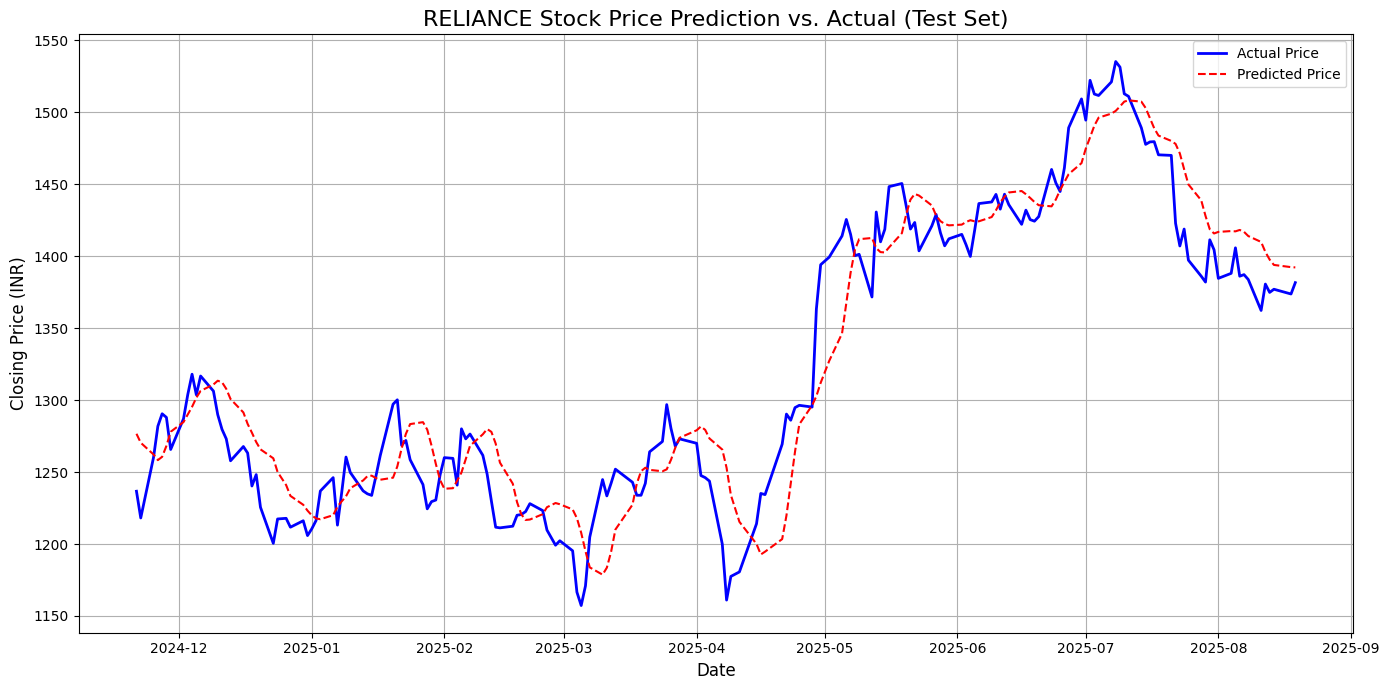

In [22]:
test_dates = df.index[training_size + look_back + 1:]

test_results = pd.DataFrame(index=test_dates)
test_results['Actual'] = y_test_original
test_results['Predicted'] = predictions

plt.figure(figsize=(14, 7))
plt.plot(test_results['Actual'], label='Actual Price', color='blue', linewidth=2)
plt.plot(test_results['Predicted'], label='Predicted Price', color='red', linestyle='--')
plt.title('RELIANCE Stock Price Prediction vs. Actual (Test Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (INR)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
